In [2]:
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################


# Run after running the individual seminar notebooks


#########################################################
#########################################################
#########################################################
#########################################################
#########################################################

import corner

import astropy
print('astropy',astropy.__version__ )
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes
from astropy.coordinates import SkyCoord
from reproject import reproject_interp      
from reproject.mosaicking import find_optimal_celestial_wcs 
import regions
import reproject
print('reproject',reproject.__version__)
import spectral_cube
print('spectral_cube',spectral_cube.__version__)
import numpy as np                          
import pylab                                
import matplotlib 
import matplotlib.gridspec as gridspec                                                                                             
import scipy
import astropy.io.fits as fits                                                          
from astropy.wcs import WCS                 
from astropy import units as u              
import pyspeckit as psk   
import astrodendro
import matplotlib.colors as colors
from matplotlib import pyplot as plt
# Suppress warnings we don't care about:
import sys, traceback
import os
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
%matplotlib inline
from matplotlib.patches import Rectangle
#%matplotlib widget
import matplotlib.gridspec as gridspec
################
# MCMC FITTING #
################

###################################################################################################

# import required modules
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
import scipy.optimize as op
import emcee
import corner


###################################################################################################

# linear fitting function, i.e. two parameter dimensions
def linear(x,a,c):
    return a*x+c

# equivalent power law function
def powlaw(x,a,b):
    return b*np.power(x,a)

# log likelihood
# according to https://ixkael.github.io/fitting-a-line-to-data-a-quick-tutorial/
def lnlikelihood(x, y, xerr, yerr, a, c):

    # only y errors:
    model = linear(x,a,c)
    return -0.5*(np.sum((y-model)**2/yerr**2 - np.log(yerr**2)))

    # # both x and y errors:
    # xyerr = np.sqrt(xerr**2. + yerr**2.)
    # model = linear(x, a, c)
    # return np.sum(-0.5*((y-model)/xyerr)**2 - 0.5*np.log(2*np.pi)-np.log(xyerr))

# negative log likelihood (required to fit maximum likelihood)
# according to https://ixkael.github.io/fitting-a-line-to-data-a-quick-tutorial/
def neg_lnlikelihood(params, x, y, xerr, yerr):
    a, c = params
    return -lnlikelihood(x, y, xerr, yerr, a, c)

# log prior
# simple flat priors on slope and intercept, large range but exclude rediculous values
def lnprior(a,c):
    if ( 0<a<10 ) and ( -10<c<10 ):
        return 0.0
    return -np.inf

# log probability function
# according to https://ixkael.github.io/fitting-a-line-to-data-a-quick-tutorial/
def lnprobability(params, x, y, xerr, yerr):
    a, c = params
    lp = lnprior(a,c)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikelihood(x, y, xerr, yerr, a, c)


####################################################################################################
# a class to the actual work and fitting
####################################################################################################

class MCMC_fit:

    def __init__(self, x, y, x_err, y_err):
        self.source = None
        self.line   = None
        self.fit    = False
        self.fit_range = [None,None]
        self.x      = np.array(x)
        self.y      = np.array(y)
        self.x_err  = np.array(x_err)
        self.y_err  = np.array(y_err)
        self.ndim = 2
        self.a    = {'ls': None, 'ml': None, 'MCMC': None, 'perc': None}
        self.c    = {'ls': None, 'ml': None, 'MCMC': None, 'perc': None}
        self.nwalkers = 50
        self.nburnin  = 500
        self.nsteps   = 5000
        self.sampler  = None
        self.samples  = None
        self.xlabel   = 'x'
        self.ylabel   = 'y'
        self.figsize  = (6,6)
        self.plotcolor = None
        self.savepath = None

    def mask_bad_values(self):
        print("masking bad values ...")
        good_vals = np.isfinite(self.x) & np.isfinite(self.y) & np.isfinite(self.x_err) & np.isfinite(self.y_err)
        self.x     = self.x[good_vals]
        self.y     = self.y[good_vals]
        self.x_err = self.x_err[good_vals]
        self.y_err = self.y_err[good_vals]

    def restrict_range(self, fit_range=[None,None]):
        self.fit_range = fit_range
        print("restricting fit to "+str(self.fit_range)+" ...")
        if not ( fit_range[0] == None ):
            in_range = self.x > self.fit_range[0]
            self.x     = self.x[in_range]
            self.y     = self.y[in_range]
            self.x_err = self.x_err[in_range]
            self.y_err = self.y_err[in_range]
        if not ( fit_range[1] == None ):
            in_range = self.x < self.fit_range[1]
            self.x     = self.x[in_range]
            self.y     = self.y[in_range]
            self.x_err = self.x_err[in_range]
            self.y_err = self.y_err[in_range]

    # least squares fit
    def least_squares_fit(self):
        print("least squares fitting ...")
        coeff, covar = curve_fit(linear, self.x, self.y, sigma=self.y_err, p0=[1, 1])
        a, c  = coeff
        a_err = covar[0][0]
        c_err = covar[1][1]
        self.a['ls'] = [a,a_err]
        self.c['ls'] = [c,c_err]

    # maximum likelihood fit
    def maximum_likelihood_fit(self):
        print("maximum likelihood fitting ...")
        result = op.minimize(neg_lnlikelihood, [self.a['ls'][0], self.c['ls'][0]], args=(self.x, self.y, self.x_err, self.y_err))
        self.a['ml'], self.c['ml'] = result["x"]

    # run MCMC fit
    def MCMC_fit(self):
        print("Bayesian MCMC fitting ...")
        # initial values for walkers from least squares and maximum likelihood fits
        init_pos = [np.array([self.a['ml'], self.c['ml']]) +1e-2*np.random.randn(self.ndim) for i in range(self.nwalkers)]
        # run MCMC
        self.sampler = emcee.EnsembleSampler(self.nwalkers, self.ndim, lnprobability, args=(self.x, self.y, self.x_err, self.y_err))
        self.sampler.run_mcmc(init_pos, self.nsteps)
        self.samples = self.sampler.chain[:, 50:, :].reshape((-1, self.ndim))
        a_percentiles, c_percentiles = np.percentile(self.samples, [16, 50, 84], axis=0).T
        self.a['MCMC'] = [a_percentiles[1], a_percentiles[2]-a_percentiles[1], a_percentiles[1]-a_percentiles[0]]
        self.c['MCMC'] = [c_percentiles[1], c_percentiles[2]-c_percentiles[1], c_percentiles[1]-c_percentiles[0]]
        self.a['perc'] = [a_percentiles[0], a_percentiles[1], a_percentiles[2]]
        self.c['perc'] = [c_percentiles[0], c_percentiles[1], c_percentiles[2]]

    # plot walkers
    def plot_walkers(self):
        print("plotting walkers ...")
        fig,ax = plt.subplots(2, sharex=True)
        for w in np.arange(self.nwalkers):
            ax[0].plot(self.sampler.chain[w,:,0], color='k', linestyle='-', alpha=0.1)
            ax[1].plot(self.sampler.chain[w,:,1], color='k', linestyle='-', alpha=0.1)
        ax[1].set_xlabel('step')
        ax[0].set_ylabel('slope a')
        ax[1].set_ylabel('intercept c')
        ax[1].set_xlim(0,self.nsteps)
        mkdir(escape_filename(self.savepath))
        fig.savefig(os.path.join(self.savepath, self.source+'.'+self.line+'.walkers.png'), dpi=300, bbox_inches='tight')

    # corner plot
    def corner_plot(self):
        print("plotting parameter distributions ...")
        fig = corner.corner(self.samples, labels=['a', 'c'], quantiles=[0.16, 0.5, 0.84], show_titles=True)
        mkdir(escape_filename(self.savepath))
        fig.savefig(os.path.join(self.savepath, self.source+'.'+self.line+'.corner.png'), dpi=300, bbox_inches='tight')

    # plot x - y relation
    def plot_x_y(self):
        print("plotting x - y relation ...")
        fig,ax = plt.subplots(figsize=self.figsize)
        ax.scatter(np.power(10,self.x), np.power(10,self.y), marker='.', color='k', label='data', s=1, alpha=0.5, zorder=0)
        x = np.logspace(np.min(self.x)-np.log10(1.5), np.max(self.x)+np.log10(1.5), 100)

        # plot most likely
        ax.plot(x, powlaw(x,self.a['MCMC'][0],np.power(10,self.c['MCMC'][0])), lw=1, color="r", zorder=2, label='50 percentile fit')

        # plot random samples
        a, c = self.samples[np.random.randint(len(self.samples), size=1)][0]
        b = np.power(10,c)
        ax.plot(x, powlaw(x,a,b), color="k", alpha=0.1, zorder=2, label='random samples')
        for a, c in self.samples[np.random.randint(len(self.samples), size=10)]:
            b = np.power(10,c)
            ax.plot(x, powlaw(x,a,b), color="k", lw=1, alpha=0.1, zorder=1)

        ax.legend()
        ax.set_xlabel(self.xlabel)
        ax.set_ylabel(self.ylabel)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim([0.75*np.power(10,np.min(self.x)),1.5*np.power(10,np.max(self.x))])
        ax.set_ylim([0.75*np.power(10,np.min(self.y)),  1.5*np.power(10,np.max(self.y))])
        mkdir(escape_filename(self.savepath))
        fig.savefig(os.path.join(self.savepath, self.source+'.'+self.line+'.xy.png'), dpi=300, bbox_inches='tight')

    def list_results(self):
        print("\n\n")
        print(self.source+" "+self.line)
        print("  "+'{:>10}{:>10}{:>10}'.format('least sq','max like','MCMC'))
        print("a "+'{:10.6f}{:10.6f}{:10.6f}'.format(self.a['ls'][0], self.a['ml'], self.a['MCMC'][0]))
        print("a-"+'{:10.6f}{:>10}{:10.6f}'.format(  self.a['ls'][1], "",           self.a['MCMC'][1]))
        print("a+"+'{:10.6f}{:>10}{:10.6f}'.format(  self.a['ls'][1], "",           self.a['MCMC'][2]))
        print("c "+'{:10.6f}{:10.6f}{:10.6f}'.format(self.c['ls'][0], self.c['ml'], self.c['MCMC'][0]))
        print("c-"+'{:10.6f}{:>10}{:10.6f}'.format(  self.c['ls'][1], "",           self.c['MCMC'][1]))
        print("c+"+'{:10.6f}{:>10}{:10.6f}'.format(  self.c['ls'][1], "",           self.c['MCMC'][2]))
        print("\n\n")

    def get_y10(self):
        """Calculate y for a scale of 10. This is more meaningful than the intercept (scale=1)."""
        # MCMC
        a  = self.a['perc'][1]
        am = self.a['perc'][0]
        ap = self.a['perc'][2]
        c  = self.c['perc'][1]
        cm = self.c['perc'][0]
        cp = self.c['perc'][2]
        # least squares
        a_ls     = self.a['ls'][0]
        a_ls_err = self.a['ls'][1]
        c_ls     = self.c['ls'][0]
        c_ls_err = self.c['ls'][1]
        y10_ls     = powlaw(10, a_ls, np.power(10,c_ls))
        y10_ls_err = np.log(10)*np.power(10,a_ls+c_ls) *np.sqrt(a_ls_err**2+c_ls_err**2)

        # best fit sigma10
        self.y10 = {'MCMC': [powlaw(10, a, np.power(10,c)), powlaw(10, am, np.power(10,cm)), powlaw(10, ap, np.power(10,cp))],
                    'ls':   [y10_ls, y10_ls_err]}

        # distribution of sigma10
        self.y10s = {'MCMC': [powlaw(10, a, np.power(10,c)) for a, c in self.samples[np.random.randint(len(self.samples), size=100)]]}


####################################################################################################
# fit and plot meta function
####################################################################################################

def fit_MCMC(log_x, log_y, log_x_err, log_y_err, source, line, savepath, xlabel=None, ylabel=None, plotcolor='r', fit_range=[None,None]):
    MCMC = MCMC_fit(log_x, log_y, log_x_err, log_y_err)
    MCMC.savepath = savepath
    MCMC.source   = source
    MCMC.line     = line
    MCMC.plotcolor = plotcolor
    MCMC.xlabel   = xlabel
    MCMC.ylabel   = ylabel

    MCMC.mask_bad_values()
    MCMC.restrict_range(fit_range)
    MCMC.least_squares_fit()
    MCMC.maximum_likelihood_fit()
    MCMC.MCMC_fit()
    MCMC.plot_walkers()
    MCMC.corner_plot()
    MCMC.plot_x_y()
    MCMC.get_y10()
    MCMC.fit = True
    MCMC.list_results()

    return MCMC


####################################################################################################
# print formatted slopes and intercepts
####################################################################################################

def print_formatted(MCMC_list, datatype):
    print(datatype)
    print('{:>8} & {:>10} & {:>6} & {:>6} & {:>6} & {:>6} & {:>6} & {:>6} & {:>8} & {:>8} & {:>8}'.format('source','line','a_16','a_50','a_84','c_16','c_50','c_84','y10','y10 -','y10 +'))
    for m in MCMC_list:
        try:
            print('{:>8} & {:>10} & {:6.2f} & {:6.2f} & {:6.2f} & {:6.2f} & {:6.2f} & {:6.2f} & {:8.1f} & {:8.1f} & {:8.1f}'.format(m.source, m.line, m.a['perc'][0], m.a['perc'][1], m.a['perc'][2], m.c['perc'][0], m.c['perc'][1], m.c['perc'][2], m.y10[0], m.y10[1], m.y10[2]))
        except:
            print('{:>8} & {:>10} & {:<10}'.format(m.source, m.line, 'no fit'))
            
def mkdir(path):
    """mkdir
    Parameters
    ----------
    path : str
        Path to directory to create
    """
    import os
    if ' ' in path:
        raise Exception("Path contains spaces! This will most probably not create the directory you want!")
    if not os.path.exists(path):
        os.system('mkdir -p '+path)
        print("Created "+path)
        
def escape_filename(str):
    """Escape the most often used characters in a string to be used as a file name.
    Parameters
    ----------
    str : str
        Input string to be escaped.
    Returns
    -------
    str
        String with escaped '(', ')'; replaced ' ' by '_' and removed '$'.
        
    """
    str = str.replace('(',r'\(')
    str = str.replace(')',r'\)')
    str = str.replace(' ',r'_')
    str = str.replace('$','')
    return str



astropy 5.1.dev153+gb740594dc
reproject 0.8
spectral_cube 0.6.1.dev22+g003ef16


4.3
5 5 2 0 2 2
(220,)
CMZ fit params and covariance: [2.96543406 0.72659516] [[ 0.06353033 -0.00742559]
 [-0.00742559  0.00093664]]
NGC253 fit params and covariance: [4.35087535 0.73553595] [[ 0.03474577 -0.00373604]
 [-0.00373604  0.00047938]]
0 5 5 2 0 0 2 2 Clear
HCO+_1_0


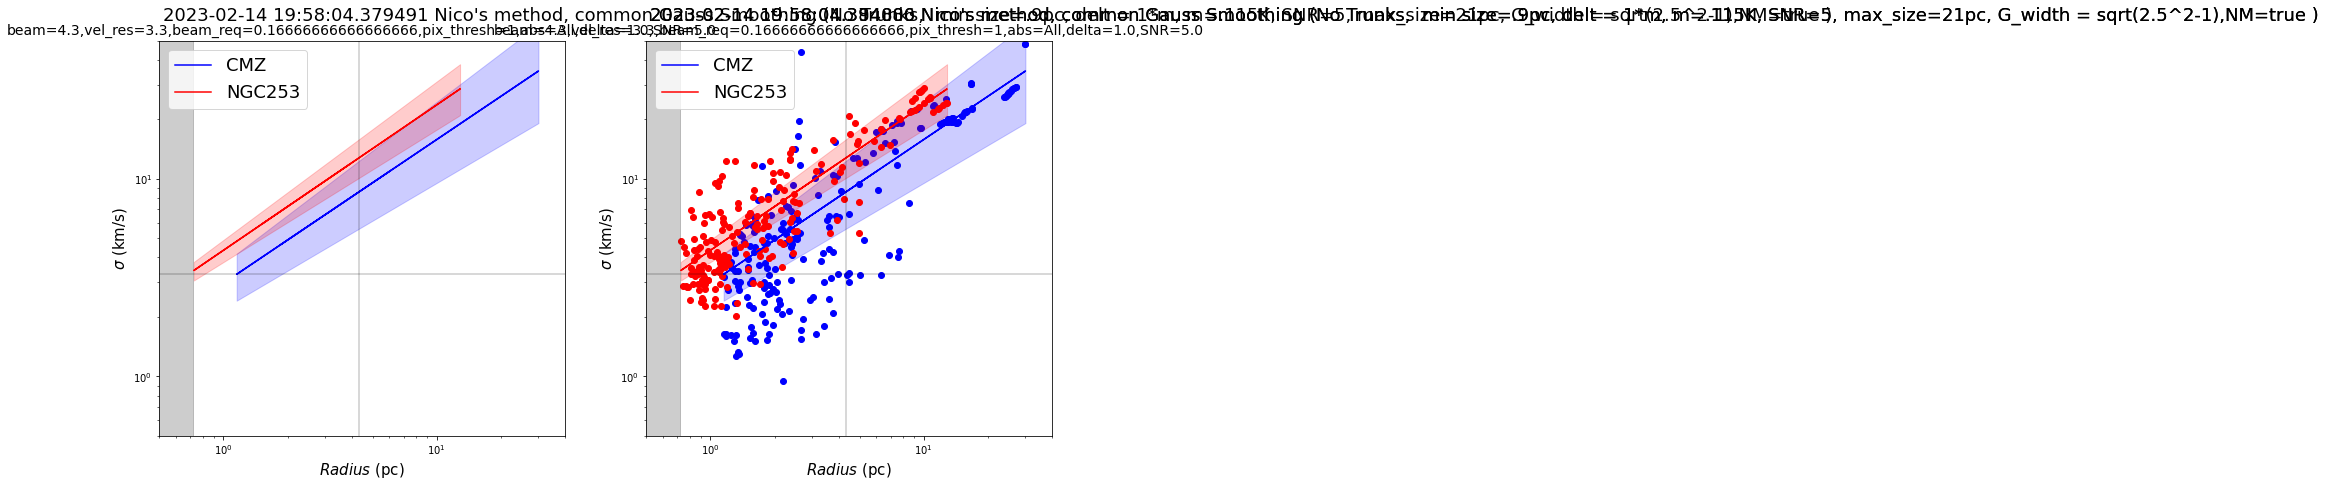

4.3
5 5 2 0 2 2
(412,)
CMZ fit params and covariance: [2.98962749 0.75370357] [[ 0.01923192 -0.00210915]
 [-0.00210915  0.00024912]]
NGC253 fit params and covariance: [4.43043846 0.76748978] [[ 0.0356971  -0.00356534]
 [-0.00356534  0.00041782]]
1 5 5 2 0 0 2 2 Clear
HCN_1_0


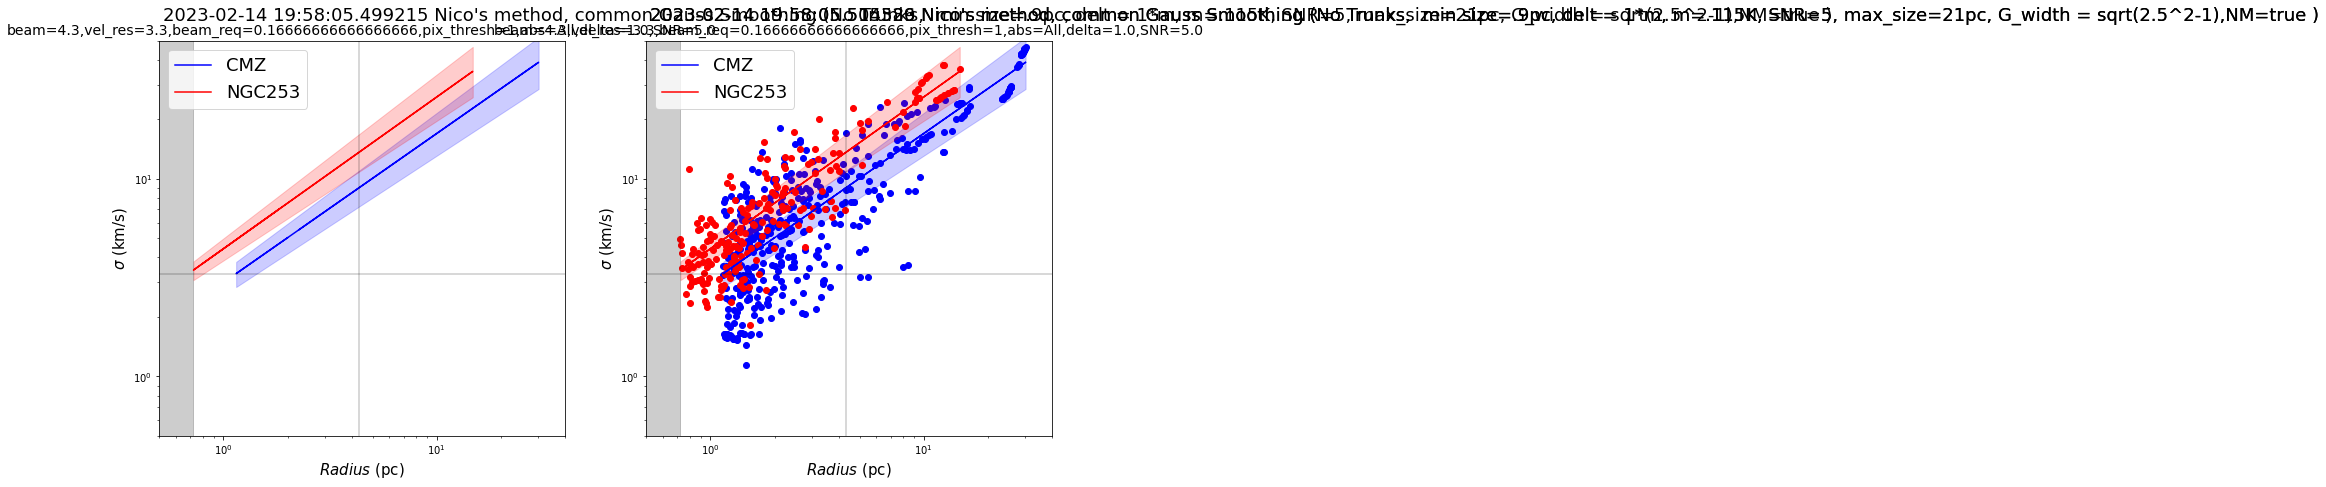

4.3
5 5 2 0 2 2
(497,)
CMZ fit params and covariance: [2.31016747 0.79823027] [[ 0.02199199 -0.00432223]
 [-0.00432223  0.00095744]]
NGC253 fit params and covariance: [3.33507326 0.79884761] [[ 0.03209427 -0.0045516 ]
 [-0.0045516   0.00083355]]
5 5 5 2 0 0 2 2 Clear
CO_J3


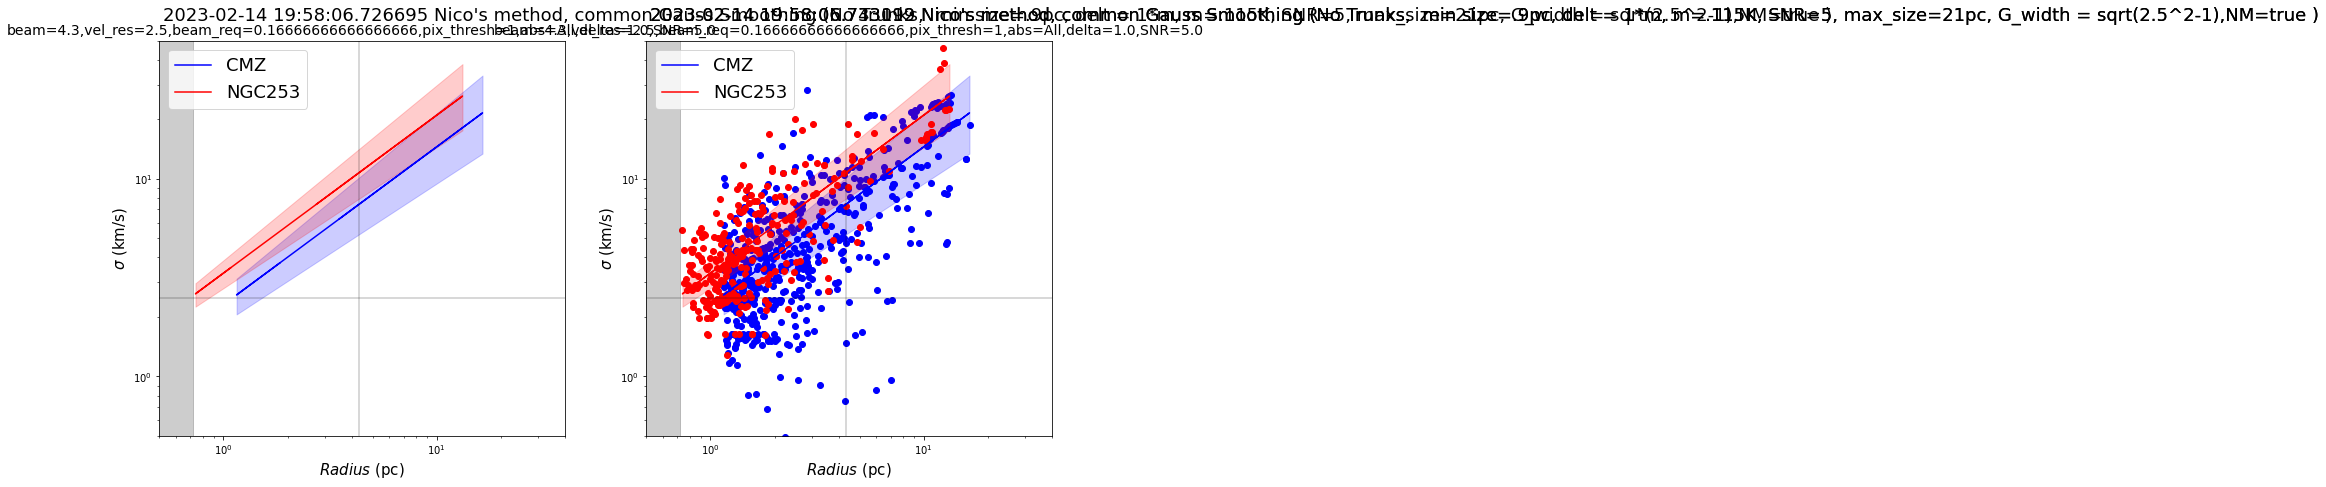

In [4]:

#All, all abs levels
#Newest method
#SL cmz


CMZLs = ["HCO+_1_0","HCN_1_0",'H13CN_1_0','H13CO+_1_0',"CO_3_2",'CO_J3']




Line_Names = ['_NGC_HCOp_J1_0_','_NGC_HCN_J1_0_','','','','_NGC_CO_J3_2_']


CMZNames=["CMZ_HCO+_J1_0_all_Cropped_4.3pc_beam__CMZ_HCO_J1_0_4.3_start70x360pc_3.3_vel_res_0.26666666666666666_beam_size_req_1_times_beam_pixels_1.0_delt_factor_5.0_SNR_NEW.fits",
         "CMZ_HCN_J1_0_all_Cropped_4.3pc_beam__CMZ_HCN_J1_0_4.3_start70x360pc_3.3_vel_res_0.26666666666666666_beam_size_req_1_times_beam_pixels_1.0_delt_factor_5.0_SNR_NEW.fits",
         "","","",
         "CMZ_CO_J3_2_all_NEW_Cropped_4.3pc_beam__CMZ_CO_J3_2_4.3_startSmoothe_to_3.3Edges70x360pc_3.3_vel_res_0.26666666666666666_beam_size_req_1_times_beam_pixels_1.0_delt_factor_5.0_SNR_NEW.fits"]
NGCNames=["HCO+ J1-0_Abs_New_Cropped_4.3pc_beam__NGC_HCOp_J1_0_70x360pc_3.3_vel_res_0.16666666666666666_beam_size_req_1_times_beam_pixels_1.0_delt_factor_5.0_SNR.fits",
         "HCN J1-0_Abs_New_Cropped_4.3pc_beam__NGC_HCN_J1_0_70x360pc_3.3_vel_res_0.16666666666666666_beam_size_req_1_times_beam_pixels_1.0_delt_factor_5.0_SNR.fits",
         "","","",
         "CO 3-2_Abs_New_4.3_start_Cropped_4.3pc_beam__NGC_CO_J3_2_70x360pc_3.3_vel_res_0.16666666666666666_beam_size_req_1_times_beam_pixels_1.0_delt_factor_5.0_SNR.fits"]


Abs_Levels = ["All","None","No Clusters", "None (m)", "None All Channels"]
Suffixes=['','_NA','_No_Clusters','None_m','None_All_Channels']
savePath='/home/ben/Documents/Grad Stuff/MM data/Result Files'
NM_mod=''

Plot=True
for i in range(0,6):
    
    
    
    
    Params=np.genfromtxt(os.path.join(savePath,"_NGC_CO_J3_2_"+"_Params"))#[iterations,iter_factor ,Line_Name,Name,ovs,min_vel,FOV,Min_res,Min_beam_req]
    iterations,iter_factor,ovs,min_vel,FOV,Min_res,Min_beam_req = int(Params[0]),Params[1],int(Params[2]),Params[3],np.array(Params[4]),Params[5],Params[6]
    iterations=6
    for kl in range(5,6):
        
        if(Line_Names[i]==''):
            break
    
        
        
        Prime_Beam = Min_res*((kl*iter_factor+1))#
        if(kl==5):
            if(i==5):
                Prime_Beam=4.3
            else:
                Prime_Beam=4.3
        print(Prime_Beam)
    
    
        for km in range(5,6):
            
            vel_prime = min_vel*((km*iter_factor+1))
            
            if(km==5):
                if(i==5):
                    vel_prime=2.5
                else:
                    vel_prime=3.3
            fig = plt.figure(1,figsize=(16,16))
            gs0 = gridspec.GridSpec(len(Suffixes), 1, figure=fig)
            
            
            
            min_space=np.array([[np.full(100,Prime_Beam/ovs)],[np.linspace(-100,1000,100)]])
            Beams_s=np.array([[np.full(100,Prime_Beam)],[np.linspace(-100,1000,100)]])
            spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,vel_prime)]])
            zeroes=np.array([[np.full(100,0)]])
            
            
            #for k5 in range(len(Suffixes)):
            for k5 in range(0,1):

                
                
                
                Suffix=Suffixes[k5]
                Abs_Level =Abs_Levels[k5]

                
                

                
                
                
                
                #fig.suptitle((CMZLs[i]+" Size-Linewidth Relation ("+str(Abs_Level)+")"), fontsize=18)
                #gs0.set_title((CMZLs[i]+" Size-Linewidth Relation ("+str(Abs_Level)+")"), fontsize=18)
                
                gs00 = gridspec.GridSpecFromSubplotSpec(iterations, iterations, subplot_spec=gs0[k5])

                
                

                for k3 in range(2,3):

                    beam_req = Min_beam_req*(k3+1)
                    if kl==5:
                        beam_req=.5/3
                    
                    beam_req_line = Beams_s*beam_req
                    for k4 in range(0,1):
                        for k6 in range(2,3):
                            delt_factor = (3/5+k6/5)

                            for k7 in range(2,3):
                                noise_factor = (3/5+k7/5)
                                
                                
                                print(kl,km,k3,k4,k6,k7)
                                
                                #ax = fig.add_subplot(gs00[k6, k7])
                                ax = fig.add_subplot(2,2,1)
                                ax2 = fig.add_subplot(2,2,2)

                                try:

                                    pix_thresh_factor = k4+1

                                    Name = CMZNames[i]
                                    
                                    #print(Name)








                                    rname=Name+"Radii"

                                    sname=Name+"Sigmas"

                                    sEname=Name+"V_err"

                                    radsBase=[[],[]]
                                    sigsBase=[[],[]]

                                    sigs_err_Base=[[],[]]
                                    radsBase[0],radsBase[1] = np.genfromtxt(os.path.join(savePath,rname+"_Leaves"+Suffix))*10**6, np.genfromtxt(os.path.join(savePath,rname+"_Branches"+Suffix))*10**6#km/s
                                    sigsBase[0] ,sigsBase[1] = np.genfromtxt(os.path.join(savePath,sname+"_Leaves"+Suffix)),np.genfromtxt(os.path.join(savePath,sname+"_Branches"+Suffix))#km/s
                                    
                                    sigs_err_Base[0] ,sigs_err_Base[1] = np.genfromtxt(os.path.join(savePath,sEname+"_Leaves"+Suffix)),np.genfromtxt(os.path.join(savePath,sEname+"_Branches"+Suffix))#km/s



                                    er_r=3 








                                    rads=np.concatenate((radsBase[0],radsBase[1]))
                                    sigs = np.concatenate((sigsBase[0],sigsBase[1]))
                                    sigs_err = np.concatenate((sigs_err_Base[0],sigs_err_Base[1]))
                                    print(np.shape(rads))

                                    from scipy.optimize import curve_fit

                                    def func(R,a,b):
                                        return a*R**(b)

                                    x   =  rads
                                    y     = sigs
                                    y_err = sigs_err

                                    try:
                                        #(Vars, CoVar) = (curve_fit(func, x, y, sigma=y_err))
                                        (Vars, CoVar) = (curve_fit(func, x, y, ))
                                    except:
                                        (Vars, CoVar) = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
                                    np.savetxt(os.path.join(savePath,Name+"_CMZ_Coeffs"+Suffix+NM_mod), Vars,fmt='%s')
                                    np.savetxt(os.path.join(savePath,Name+"_CMZ_Coeff_CoVar"+Suffix+NM_mod),CoVar ,fmt='%s')

                                    np.savetxt(os.path.join(savePath,Name+"_CMZ_Fit_weights"+Suffix+NM_mod),[(len(sigs))] ,fmt='%s')
                                    #np.savetxt(CMZName+"_CMZ_Coeffs"+Suffix, Vars2,fmt='%s')
                                    #np.savetxt(CMZName+"_CMZ_Coeff_CoVar"+Suffix,CoVar2 ,fmt='%s')
                                    fx = np.linspace(min(x),max(x),50)
                                    if Plot:
                                        print("CMZ fit params and covariance:",Vars,CoVar)
                                        gggg=ax.plot(x,func(x,Vars[0],Vars[1]),color="Blue",label="CMZ")
                                        ax.fill_between(fx,func(fx,Vars[0]+np.sqrt(CoVar[0][0])*er_r,Vars[1]+np.sqrt(CoVar[1][1])*er_r),func(fx,Vars[0]-np.sqrt(CoVar[0][0])*er_r,Vars[1]-np.sqrt(CoVar[1][1])*er_r),alpha=.2,color="Blue")
                                        #ax.errorbar(x, y, yerr=y_err,lolims=True, uplims=True,fmt="o",color="Blue")
                                        
                                        ax.fill_betweenx(beam_req_line[1][0],beam_req_line[0][0] ,zeroes[0][0], alpha=.1,color="Black")
                                        ax.plot(Beams_s[0][0],Beams_s[1][0], alpha=.1,color="Black")

                                        spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,vel_prime)]])

                                        ax.plot(spec[0][0],spec[1][0], alpha=.1,color="Black")

                                        #ax.scatter(x,y,color="Red",alpha=.51,s=50)



                                        ax.set_xlabel(r'$R_{astrodendro}$ (pc)',fontsize=15)
                                        ax.set_ylabel(r'$\sigma   (km/s)$',fontsize=15)
                                        ax.set_yscale('log')
                                        ax.set_xscale('log')
                                        #string = ("NGC253 (Binned"+Suffix+"): a="+str(round(Vars[0],3))+" +-" + str(round(np.sqrt(CoVar[0][0]),3)) +", b="+str(round(Vars[1],3))+"+-" + str(round(np.sqrt(CoVar[1][1]),3)) )




                                        #axA.annotate(s=string,fontsize=18,xy=(0.01,.01+0.025*Index),xycoords="axes fraction")
                                        ax.set_xlim(0.5,40.0)
                                        ax.set_ylim(0.5,50.0)

                                        #axA.legend(loc='upper left',fontsize=18)

                                        import datetime
                                        now = str(datetime.datetime.now())
                                        string=now+ " "+ "Nico's method, common Gauss Smoothing (No Trunks,  min size=.9pc, delt = 1*m, m=.115K, SNR=5, max_size=21pc, G_width = sqrt(2.5^2-1),NM=true )"
                                        ax.annotate(s=string,fontsize=18,xy=(0.01,1.05),xycoords="axes fraction")
                                        
                                        
                                        ax.set_title(("beam={0},vel_res={1},beam_req={2},pix_thresh={3},abs={4},delta={5},SNR={6}".format(Prime_Beam,vel_prime,beam_req,pix_thresh_factor,Abs_Level,delt_factor,noise_factor*5)), fontsize=14)
                                        
                                        gggsag=ax2.plot(x,func(x,Vars[0],Vars[1]),color="Blue",label="CMZ")
                                        gggasfg=ax2.scatter(x,y,color="Blue")
                                        ax2.fill_between(fx,func(fx,Vars[0]+np.sqrt(CoVar[0][0])*er_r,Vars[1]+np.sqrt(CoVar[1][1])*er_r),func(fx,Vars[0]-np.sqrt(CoVar[0][0])*er_r,Vars[1]-np.sqrt(CoVar[1][1])*er_r),alpha=.2,color="Blue")
                                        #ax2.errorbar(x, y, yerr=y_err,lolims=True, uplims=True,fmt="o",color="Blue")
                                        
                                        ax2.fill_betweenx(beam_req_line[1][0],beam_req_line[0][0] ,zeroes[0][0], alpha=.1,color="Black")
                                        ax2.plot(Beams_s[0][0],Beams_s[1][0], alpha=.1,color="Black")

                                        spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,vel_prime)]])

                                        ax2.plot(spec[0][0],spec[1][0], alpha=.1,color="Black")

                                        #ax2.scatter(x,y,color="Red",alpha=.51,s=50)



                                        ax2.set_xlabel(r'$Radius$ (pc)',fontsize=15)
                                        ax2.set_ylabel(r'$\sigma  $ (km/s)',fontsize=15)
                                        ax2.set_yscale('log')
                                        ax2.set_xscale('log')
                                        #string = ("NGC253 (Binned"+Suffix+"): a="+str(round(Vars[0],3))+" +-" + str(round(np.sqrt(CoVar[0][0]),3)) +", b="+str(round(Vars[1],3))+"+-" + str(round(np.sqrt(CoVar[1][1]),3)) )




                                        #ax2A.annotate(s=string,fontsize=18,xy=(0.01,.01+0.025*Index),xycoords="ax2es fraction")
                                        ax2.set_xlim(0.5,40.0)
                                        ax2.set_ylim(0.5,50.0)

                                        #ax2A.legend(loc='upper left',fontsize=18)

                                        import datetime
                                        now = str(datetime.datetime.now())
                                        string=now+ " "+ "Nico's method, common Gauss Smoothing (No Trunks,  min size=.9pc, delt = 1*m, m=.115K, SNR=5, max_size=21pc, G_width = sqrt(2.5^2-1),NM=true )"
                                        ax2.annotate(s=string,fontsize=18,xy=(0.01,1.05),xycoords="axes fraction")
                                        
                                        
                                        ax2.set_title(("beam={0},vel_res={1},beam_req={2},pix_thresh={3},abs={4},delta={5},SNR={6}".format(Prime_Beam,vel_prime,beam_req,pix_thresh_factor,Abs_Level,delt_factor,noise_factor*5)), fontsize=14)
                                        
                                    
                                    pix_thresh_factor = k4+1

                                    Name = NGCNames[i]
                                    #print(Name)








                                    rname=Name+"Radii"

                                    sname=Name+"Sigmas"

                                    sEname=Name+"V_err"

                                    radsBase=[[],[]]
                                    sigsBase=[[],[]]

                                    sigs_err_Base=[[],[]]
                                    radsBase[0],radsBase[1] = np.genfromtxt(os.path.join(savePath,rname+"_Leaves"+Suffix))*10**6, np.genfromtxt(os.path.join(savePath,rname+"_Branches"+Suffix))*10**6#km/s
                                    sigsBase[0] ,sigsBase[1] = np.genfromtxt(os.path.join(savePath,sname+"_Leaves"+Suffix)),np.genfromtxt(os.path.join(savePath,sname+"_Branches"+Suffix))#km/s

                                    sigs_err_Base[0] ,sigs_err_Base[1] = np.genfromtxt(os.path.join(savePath,sEname+"_Leaves"+Suffix)),np.genfromtxt(os.path.join(savePath,sEname+"_Branches"+Suffix))#km/s



                                    er_r=3








                                    rads=np.concatenate((radsBase[0],radsBase[1]))
                                    sigs = np.concatenate((sigsBase[0],sigsBase[1]))
                                    sigs_err = np.concatenate((sigs_err_Base[0],sigs_err_Base[1]))


                                    from scipy.optimize import curve_fit

                                    def func(R,a,b):
                                        return a*R**(b)

                                    x   =  rads
                                    y     = sigs
                                    y_err = sigs_err

                                    try:
                                        #(Vars, CoVar) = (curve_fit(func, x, y, sigma=y_err))
                                        (Vars, CoVar) = (curve_fit(func, x, y))
                                    except:
                                        (Vars, CoVar) = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
                                    np.savetxt(os.path.join(savePath,Name+"_NGC253_Coeffs"+Suffix+NM_mod), Vars,fmt='%s')
                                    np.savetxt(os.path.join(savePath,Name+"_NGC253_Coeff_CoVar"+Suffix+NM_mod),CoVar ,fmt='%s')
                                    np.savetxt(os.path.join(savePath,Name+"_NGC253_Fit_weights"+Suffix+NM_mod),[(len(sigs))] ,fmt='%s')
                                    #np.savetxt(CMZName+"_CMZ_Coeffs"+Suffix, Vars2,fmt='%s')
                                    #np.savetxt(CMZName+"_CMZ_Coeff_CoVar"+Suffix,CoVar2 ,fmt='%s')
                                    fx = np.linspace(min(x),max(x),50)
                                    if Plot:
                                        print("NGC253 fit params and covariance:",Vars,CoVar)
                                        gggg=ax.plot(x,func(x,Vars[0],Vars[1]),color="Red",label="NGC253")
                                        
                                        ax.fill_between(fx,func(fx,Vars[0]+np.sqrt(CoVar[0][0])*er_r,Vars[1]+np.sqrt(CoVar[1][1])*er_r),func(fx,Vars[0]-np.sqrt(CoVar[0][0])*er_r,Vars[1]-np.sqrt(CoVar[1][1])*er_r),alpha=.2,color="Red")
                                        #ax.errorbar(x, y, yerr=y_err,lolims=True, uplims=True,fmt="o",color="Blue")

                                        ax.fill_betweenx(beam_req_line[1][0],beam_req_line[0][0] ,zeroes[0][0], alpha=.1,color="Black")
                                        ax.plot(Beams_s[0][0],Beams_s[1][0], alpha=.1,color="Black")

                                        spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,vel_prime)]])

                                        ax.plot(spec[0][0],spec[1][0], alpha=.1,color="Black")

                                        #ax.scatter(x,y,color="Red",alpha=.51,s=50)



                                        ax.set_xlabel(r'$Radius$ (pc)',fontsize=15)
                                        ax.set_ylabel(r'$\sigma  $ (km/s)',fontsize=15)
                                        ax.set_yscale('log')
                                        ax.set_xscale('log')
                                        #string = ("NGC253 (Binned"+Suffix+"): a="+str(round(Vars[0],3))+" +-" + str(round(np.sqrt(CoVar[0][0]),3)) +", b="+str(round(Vars[1],3))+"+-" + str(round(np.sqrt(CoVar[1][1]),3)) )




                                        #axA.annotate(s=string,fontsize=18,xy=(0.01,.01+0.025*Index),xycoords="axes fraction")
                                        ax.set_xlim(0.5,40.0)
                                        ax.set_ylim(0.5,50.0)

                                        #axA.legend(loc='upper left',fontsize=18)
                                        
                                        gggsag=ax2.plot(x,func(x,Vars[0],Vars[1]),color="Red",label="NGC253")
                                        gggasfg=ax2.scatter(x,y,color="Red")
                                        ax2.fill_between(fx,func(fx,Vars[0]+np.sqrt(CoVar[0][0])*er_r,Vars[1]+np.sqrt(CoVar[1][1])*er_r),func(fx,Vars[0]-np.sqrt(CoVar[0][0])*er_r,Vars[1]-np.sqrt(CoVar[1][1])*er_r),alpha=.2,color="Red")
                                        #ax2.errorbar(x, y, yerr=y_err,lolims=True, uplims=True,fmt="o",color="Blue")
                                        
                                        ax2.fill_betweenx(beam_req_line[1][0],beam_req_line[0][0] ,zeroes[0][0], alpha=.1,color="Black")
                                        ax2.plot(Beams_s[0][0],Beams_s[1][0], alpha=.1,color="Black")

                                        spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,vel_prime)]])

                                        ax2.plot(spec[0][0],spec[1][0], alpha=.1,color="Black")

                                        #ax2.scatter(x,y,color="Red",alpha=.51,s=50)



                                        ax2.set_xlabel(r'$Radius$ (pc)',fontsize=15)
                                        ax2.set_ylabel(r'$\sigma  $ (km/s)',fontsize=15)
                                        ax2.set_yscale('log')
                                        ax2.set_xscale('log')
                                        #string = ("NGC253 (Binned"+Suffix+"): a="+str(round(Vars[0],3))+" +-" + str(round(np.sqrt(CoVar[0][0]),3)) +", b="+str(round(Vars[1],3))+"+-" + str(round(np.sqrt(CoVar[1][1]),3)) )




                                        #ax2A.annotate(s=string,fontsize=18,xy=(0.01,.01+0.025*Index),xycoords="ax2es fraction")
                                        ax2.set_xlim(0.5,40.0)
                                        ax2.set_ylim(0.5,50.0)

                                        #ax2A.legend(loc='upper left',fontsize=18)

                                        import datetime
                                        now = str(datetime.datetime.now())
                                        string=now+ " "+ "Nico's method, common Gauss Smoothing (No Trunks,  min size=.9pc, delt = 1*m, m=.115K, SNR=5, max_size=21pc, G_width = sqrt(2.5^2-1),NM=true )"
                                        ax2.annotate(s=string,fontsize=18,xy=(0.01,1.05),xycoords="axes fraction")
                                        
                                        
                                        ax2.set_title(("beam={0},vel_res={1},beam_req={2},pix_thresh={3},abs={4},delta={5},SNR={6}".format(Prime_Beam,vel_prime,beam_req,pix_thresh_factor,Abs_Level,delt_factor,noise_factor*5)), fontsize=14)



                                    ax.legend(loc='upper left',fontsize=18)
                                    ax2.legend(loc='upper left',fontsize=18)

                                    print(i,kl,km,k3,k4,k5,k6,k7,"Clear")
                                except Exception as e:
                                    print(e)
                                    print(i,kl,km,k3,k4,k5,k6,k7,"F")
                                    print(Name)
                                    print("Failed")
                                    print("-"*60)
                                    traceback.print_exc(file=sys.stdout)
                                if Plot:
                                
                                    plt.tight_layout(pad=5, w_pad=5 ,h_pad=50.0)
                                    print(CMZLs[i])
                                    pylab.show()
                                    fname = "All_"+str(Prime_Beam)+"_beam_"+str(vel_prime) +"_vel_res_"+Suffix+"_.jpeg"
                                    fig.savefig(bbox_inches='tight',fname=fname)
                                    
                                    
                                    